In [25]:
import os
import math
from pathlib import Path
import IPython
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm import tqdm
import soundfile as sf
from IPython.display import Audio
from src.data import load_metadata, find_paths
from nltk.tokenize import WordPunctTokenizer
import pandas as pd
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from joblib import dump, load
from sklearn.metrics import classification_report
from sklearn import metrics
import random
from read_data import id_to_path_and_start
from SSL import select_query,play_audio,generate_evaluation_dictionary,run_grid_search_cv,run
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

opensmile_uri="/unix/cdtdisspotify/index/opensmile"
yamnet_embedding_uri="/unix/cdtdisspotify/index/yamnet/embedding"
yamnet_scores_uri="/unix/cdtdisspotify/index/yamnet/scores"
bm25_uri="/unix/cdtdisspotify/index/runs/UCL_pyserini_bm25.txt"
audio_uri='/unix/cdtdisspotify/data/spotify-podcasts-2020/podcasts-audio'
sample_rate=44100
RANDOM_SEED=0

# load all data
functionals_df=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/functionals_df.csv')
functionals_h=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/functionals_h.csv')
scores_df=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/scores_df.csv')
scores_h=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/scores_hl.csv')

human_labeled=pd.read_csv('/unix/cdtdisspotify/haoyueyu/podcast-dataset/data/labeled.csv')
raw_data=pd.read_csv(bm25_uri,sep='\t',header=None)


# Entertaining

In [ ]:
# #__________________labeling_________________________________________
#
scores_df['label']=2
scores_h['label']=-1
for i,r in scores_h.iterrows():
    if 'funny' in human_labeled.entertaining[i]:
        scores_h.loc[i,'label']=1
 
df_all = pd.concat([scores_df,scores_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:521])
df_std=df_all.copy()
df_std.iloc[:,:521]=standard_transform.transform(df_all.iloc[:,:521])
labeled_data=df_std.iloc[-200:,:]

#___________________Feature Selection__________________________________________
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:521], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
yamnet_important_features=df_std.columns[:521][model.get_support()]
print('Number of features selected %d' %len(yamnet_important_features)) 

df_raw_reduced=df_std[yamnet_important_features]
df_raw_reduced.insert(0,'label', df_std.label)

labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]

np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]
#_________________clustering_______________________________________________________
db = DBSCAN(eps=10, min_samples=100)
df_cluster=df_raw_reduced.copy()
db.fit(df_cluster.iloc[:,1:])
labels = db.labels_ 
df_cluster['cluster_db'] = labels
df_cluster['cluster_db'].value_counts()
#_______________Load ACTIVE LEARNING:____________________________________________________
print('AL start: load initial classifier: ')
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(1,10,2) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[0])
X_train_update,y_train_update,clf,unlabeled_update,evaluation_df=run(20,X_train,y_train,df_cluster,clf,test_data,unlabeled_data,evaluation_df)
print('Run complete! ')
#dump(clf, 'ssl/Entertaining/test.joblib')   
#evaluation_df.to_csv('ssl/Entertaining/evaluation_df.csv')

In [ ]:
evaluation_df.plot(xticks=np.arange(0, 21, 1),figsize=(10,5),grid=True,title='Entertaining: Active Learning Evaluation',xlabel='query')

# Subjective

In [ ]:
# #__________________labeling_________________________________________
#
functionals_df['label']=2
functionals_h['label']=-1
for i,r in functionals_h.iterrows():
    if 'pproval' in human_labeled.subjective[i] :
        functionals_h.loc[i,'label']=1
df_all = pd.concat([functionals_df,functionals_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:88])
df_std=df_all.copy()
df_std.iloc[:,:88]=standard_transform.transform(df_all.iloc[:,:88])
labeled_data=df_std.iloc[-200:,:]

#___________________Feature Selection__________________________________________
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:88], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
opensmile_important_features=df_std.columns[:88][model.get_support()]
print('Number of features selected %d' %len(opensmile_important_features)) 

# Standardise features
df_raw_reduced=df_std[opensmile_important_features]
df_raw_reduced.insert(0,'label', df_std.label)

labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]

np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

#_________________clustering_______________________________________________________

db = DBSCAN(eps=10, min_samples=100)
df_cluster=df_raw_reduced.copy()
db.fit(df_cluster.iloc[:,1:])
labels = db.labels_ 
df_cluster['cluster_db'] = labels
df_cluster['cluster_db'].value_counts()
print('AL start: load initial classifier: ')
from sklearn.ensemble import RandomForestClassifier
#_______________Load ACTIVE LEARNING:____________________________________________________
model=SVC(kernel='rbf',probability=True)
C_range = np.logspace(-1, 5, 6)
gamma_range = np.logspace(-7, 1, 9)
param_grid =dict(gamma=gamma_range, C=C_range)
clf=run_grid_search_cv(X_train,y_train,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[0])
X_train_update,y_train_update,clf,unlabeled_update,evaluation_df=run(20,X_train,y_train,df_cluster,clf,test_data,unlabeled_data,evaluation_df)
print('Run complete! ')
#dump(clf, 'ssl/Subjective/test.joblib')   
#evaluation_df.to_csv('ssl/Subjective/evaluation_df.csv')

<AxesSubplot:title={'center':'Subjective: Active Learning Evaluation'}, xlabel='query'>

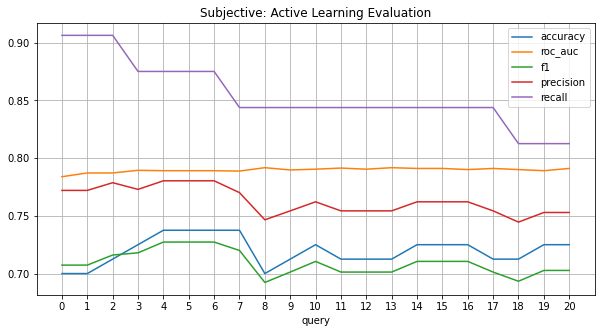

In [21]:
evaluation_df.plot(xticks=np.arange(0, 21, 1),figsize=(10,5),grid=True,title='Subjective: Active Learning Evaluation',xlabel='query')

# Discussion

In [ ]:
# #__________________labeling_________________________________________
#
functionals_df['label']=2
functionals_h['label']=-1
for i,r in functionals_h.iterrows():
    if 'debate' in human_labeled.discussion[i] or  'conversation' in human_labeled.discussion[i]:
        functionals_h.loc[i,'label']=1
 
df_all = pd.concat([functionals_df,functionals_h],axis=0, ignore_index=True)
standard_transform = StandardScaler().fit(df_all.iloc[:,:88])
df_std=df_all.copy()
df_std.iloc[:,:88]=standard_transform.transform(df_all.iloc[:,:88])
labeled_data=df_std.iloc[-200:,:]

#___________________Feature Selection__________________________________________
clf = ExtraTreesClassifier(n_estimators=50,random_state=RANDOM_SEED)
clf = clf.fit(labeled_data.iloc[:,:88], labeled_data.label)
model = SelectFromModel(clf, prefit=True)
opensmile_important_features=df_std.columns[:88][model.get_support()]
print('Number of features selected %d' %len(opensmile_important_features)) 

# Standardise features
df_raw_reduced=df_std[opensmile_important_features]
df_raw_reduced.insert(0,'label', df_std.label)
#
labeled_data=df_raw_reduced.iloc[-200:,:]
unlabeled_data=df_raw_reduced.iloc[:-200, 1:]

np.random.seed(RANDOM_SEED)
training_indices = list(labeled_data.index[0]+np.random.permutation(199))[:120]
X_train=labeled_data.loc[training_indices,:].iloc[:,1:]
y_train=labeled_data.label[training_indices]
test_data=labeled_data.loc[[ind for ind in labeled_data.index if ind not in training_indices],:]

# Over-sampling the training set
ros = RandomOverSampler(random_state=RANDOM_SEED)
X_resampled, y_resampled = ros.fit_resample(X_train,y_train)

#_________________clustering_______________________________________________________
db = DBSCAN(eps=10, min_samples=100)
df_cluster=df_raw_reduced.copy()
db.fit(df_cluster.iloc[:,1:])
labels = db.labels_ 
df_cluster['cluster_db'] = labels

#_______________Load ACTIVE LEARNING:____________________________________________________
print('AL start: load initial classifier: ')
model=RandomForestClassifier(random_state=RANDOM_SEED)
n_estimators_range = np.arange(10,30,5)
criterion_range = ['gini','entropy']
min_samples_leaf_range=np.arange(2,20,4) 
param_grid=dict(n_estimators=n_estimators_range, criterion=criterion_range,min_samples_leaf=min_samples_leaf_range)
clf=run_grid_search_cv(X_resampled, y_resampled,model,param_grid)
y_predict=clf.predict(test_data.iloc[:,1:])
y_score=clf.predict_proba(test_data.iloc[:,1:])
evaluation_dic=generate_evaluation_dictionary(test_data.label, y_predict,y_score)
evaluation_df=pd.DataFrame(evaluation_dic,index=[0])
X_train_update,y_train_update,clf,unlabeled_update,evaluation_df=run(20,X_resampled, y_resampled ,df_cluster,clf,test_data,unlabeled_data,evaluation_df)
print('Run complete! ')
#dump(clf, 'ssl/Subjective/test.joblib')   
#evaluation_df.to_csv('ssl/Subjective/evaluation_df.csv')

In [ ]:
evaluation_df.plot(xticks=np.arange(0, 21, 1),figsize=(10,5),grid=True,title='Discussion: Active Learning Evaluation',xlabel='query')